In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import tick_params

In [36]:
# Load the data
df = pd.read_excel("../data/raw/premiums.xlsx")

print("Data rows and columns: ", df.shape)

df.head()

Data rows and columns:  (50000, 13)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [37]:
# make all column names in python convention
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

In [38]:
# Check for missing values
df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [39]:
# Since the missing values are few and we have a large dataset, we can drop them
df.dropna(inplace=True)
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [40]:
# Check for duplicates
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [41]:
# Check for summary of the numerical columns
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


### Handle Outliers and Anomalies In The Numerical Columns

In [42]:
df[df["number_of_dependants"] < 0]["number_of_dependants"].unique()

array([-3, -1])

In [43]:
df["number_of_dependants"] = abs(df["number_of_dependants"])
print("Number of Records with Negative Number of Dependents", df[df["number_of_dependants"] < 0].shape[0])

Number of Records with Negative Number of Dependents 0


In [44]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols

['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount']

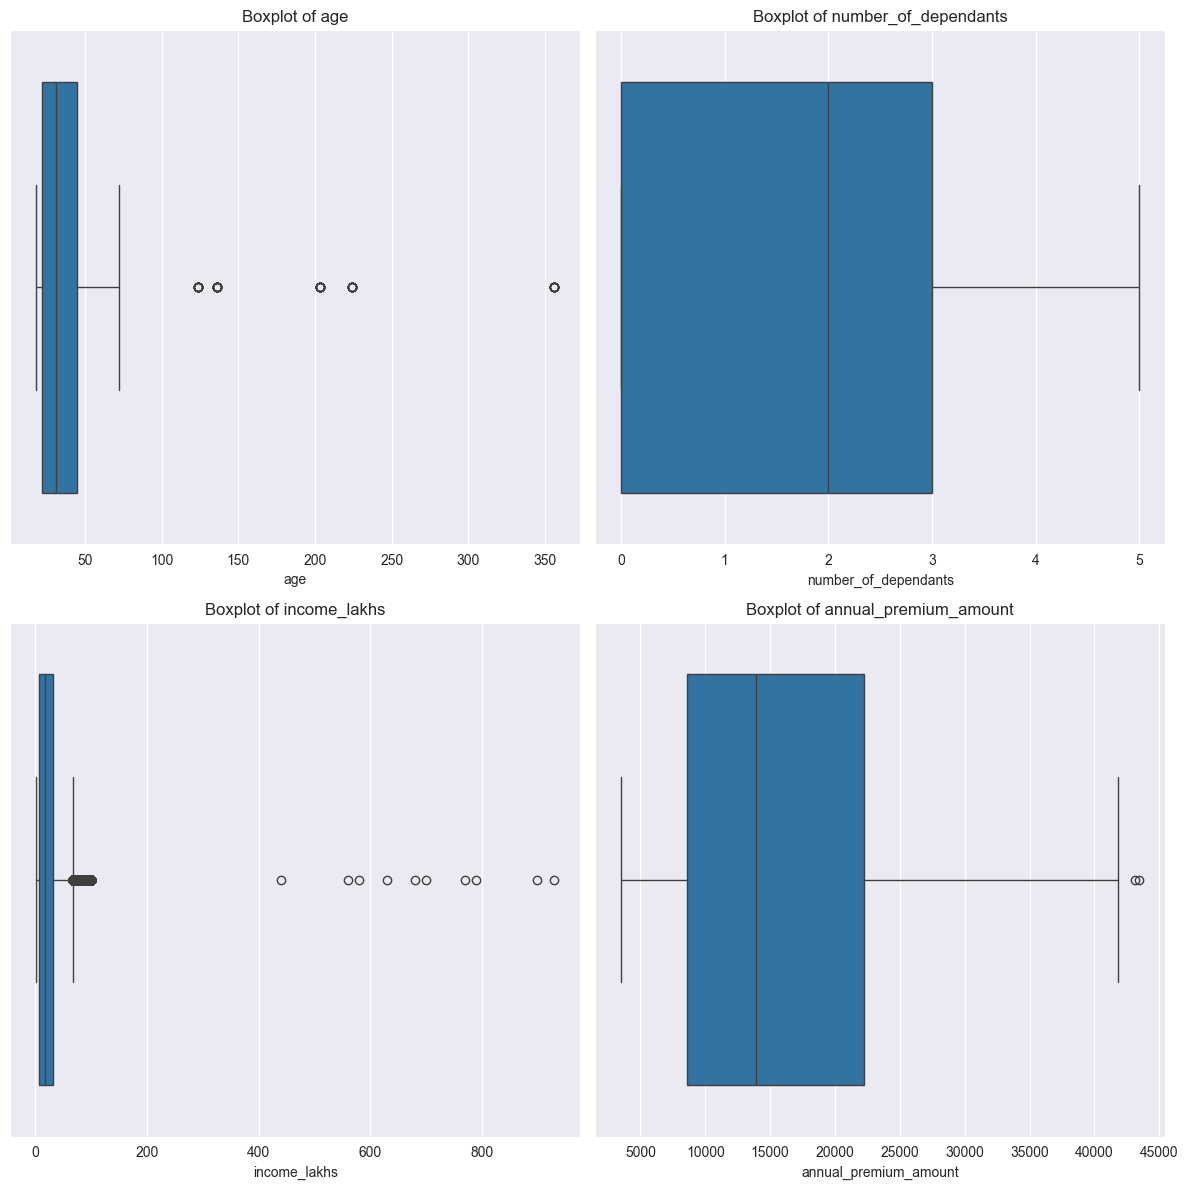

In [45]:
# Number of plots per row
plots_per_row = 2
num_cols = len(numeric_cols)
num_rows = (num_cols + plots_per_row - 1) // plots_per_row  # Calculate the required number of rows

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(12, 6 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

# Hide any unused subplots
for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Outliers and Anomalies Insights

- The `number_of_dependants` is free of outliers as all points are within the whiskers of the boxplot and we removed negative values.
- The `age` column has a few outliers above the upper whisker which by common sense would not be possible.
- The `annual_premium_amount` column can remain as it is because in reality some amounts are rather high, the outliers are not too far from the whiskers, and they are very few in number.
- Overall, the outliers can even be dropped since they are few and we have a large dataset.

In [46]:
# Handle Outliers in the age column
print("Unique outlier age values: ", df[df["age"] > 100]["age"].unique())
print("Number of Records with age Greater Than 100:", df[df["age"] > 100].shape[0])

# From business understanding, we can assume that the age of a person cannot be greater than 100
# So far we have dropped very few records so we drop this small number of records
df1 = df[df["age"] <= 100]

Unique outlier age values:  [224 124 136 203 356]
Number of Records with age Greater Than 100: 58


In [47]:
# Handle outliers in the income column

def get_iqr_bounds(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound

lower_bound, upper_bound = get_iqr_bounds(df1, "income_lakhs")
print("Income Lower Bound: ", lower_bound)
print("Income Upper Bound: ", upper_bound)
print("99.9th percentile of income: ", df1["income_lakhs"].quantile(0.999))

Income Lower Bound:  -29.0
Income Upper Bound:  67.0
99.9th percentile of income:  100.0


In [48]:
# Even though the 99.9th percentile is greater than IQR upper bound, 100 lakhs = 1 crore is a reasonable income
# So our upper bound will be the 99.9th percentile
upper_income_limit = df1["income_lakhs"].quantile(0.999)
print(df[df["income_lakhs"] > upper_income_limit].shape[0])

# Since the number of records above the limit is very small, we can drop them
df2 = df1[df1["income_lakhs"] <= upper_income_limit]
df2["income_lakhs"].describe()

10


count    49908.000000
mean        22.889897
std         22.170699
min          1.000000
25%          7.000000
50%         17.000000
75%         31.000000
max        100.000000
Name: income_lakhs, dtype: float64

### Univariate Analysis of Numerical Columns

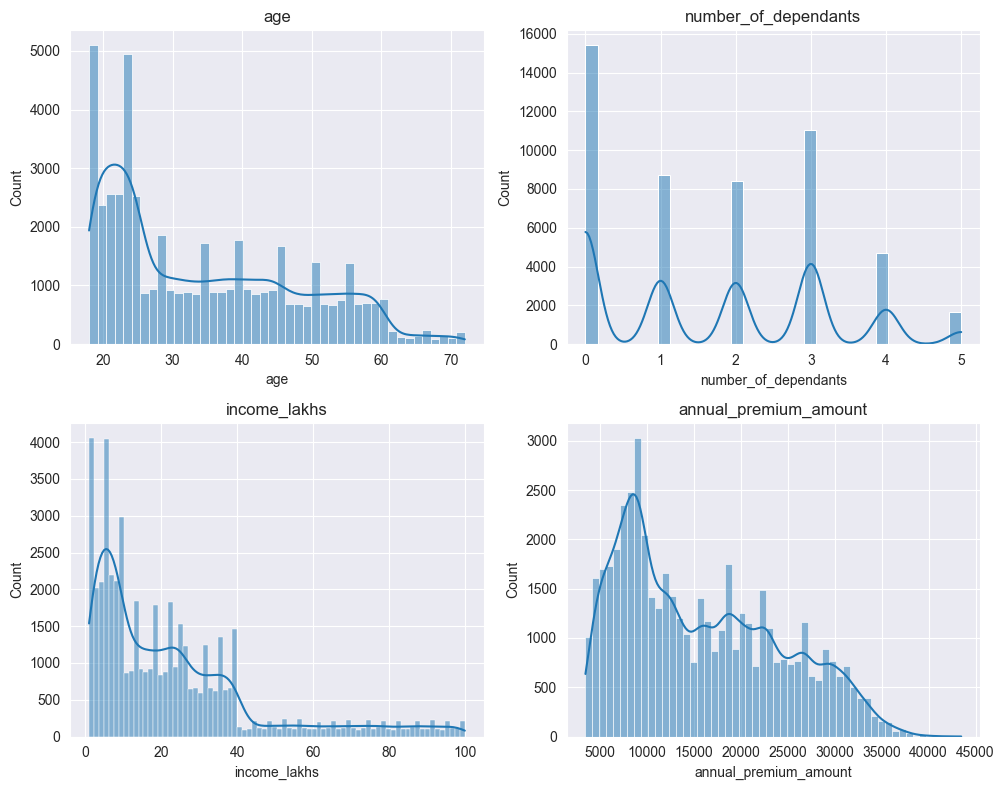

In [49]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numeric_cols):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

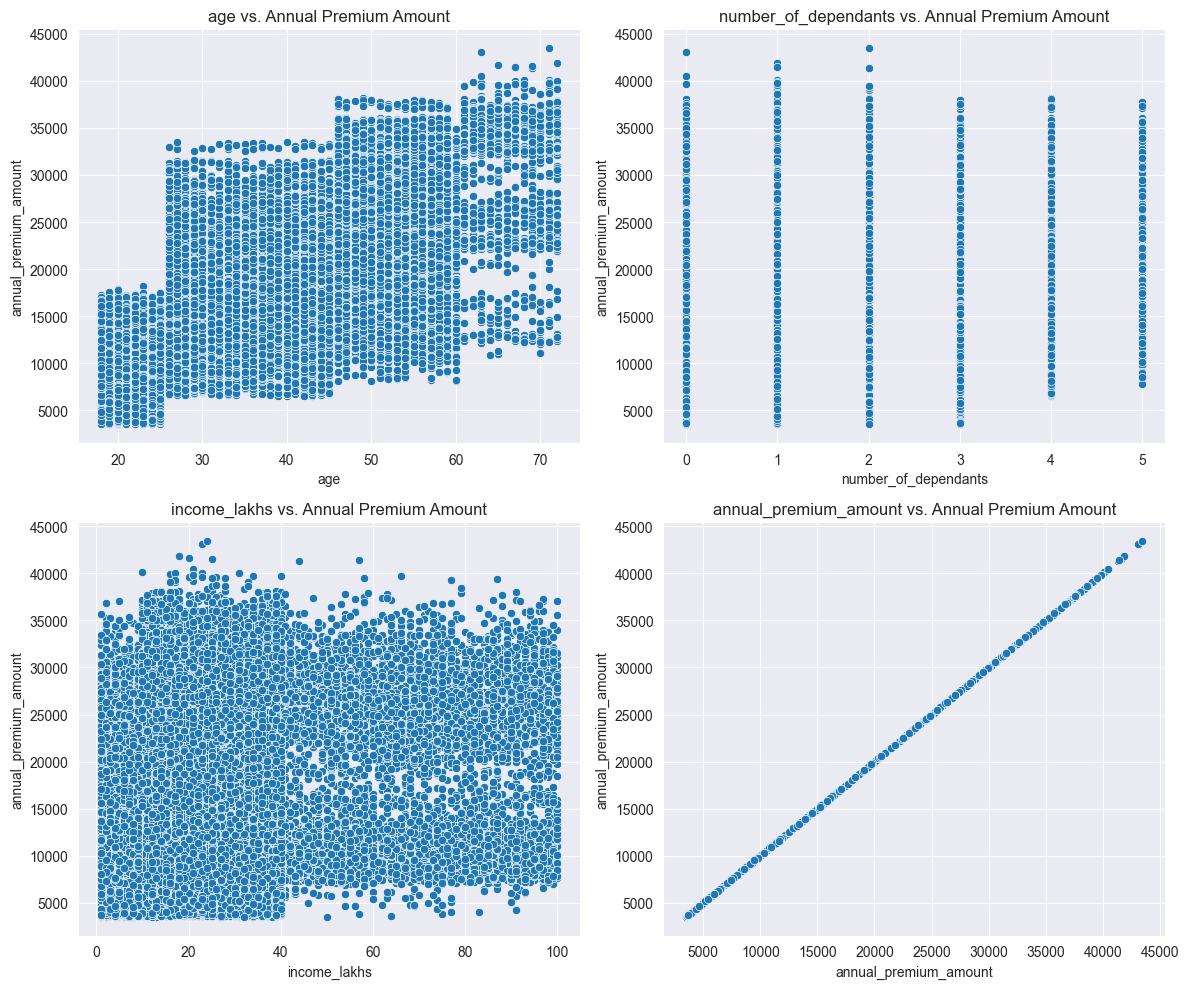

In [50]:
# For each numerical column, make a scatter plot against the target variable
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for i, column in enumerate(numeric_cols):
    ax = axs[i//2, i%2]
    sns.scatterplot(x=column, y="annual_premium_amount", data=df2, ax=ax)
    ax.set_title(f"{column} vs. Annual Premium Amount")

plt.tight_layout()
plt.show()

### Insights from Univariate Analysis of Numerical Columns
- Most of the numeric columns are right skewed which makes sense because most people tend to have values towards the middle to lower end of the range. This is especially common for income and age where the majority of people are younger and have lower incomes.
- The `number of dependents` column is seemingly uniformly distributed from 0-4 dependents while there are half as many people with 5 dependents as any 1 column from 0-4 dependents.
- `age` is positively correlated with 'annual_premium_amount' which is expected because older people are more likely to have higher premiums. The different clusters of age have cutoffs for the maximum and minimum premium amount.
- `income_lakhs` while still correlated is less influential than age on `annual_premium_amount` because the 2 obvious clusters (0-40) and (40-100) have a wide range of premium amounts, but only differ in the minimum premium cutoff.

### Categorical Columns

In [51]:
categorical_cols = df2.select_dtypes(include="object").columns.tolist()
categorical_cols

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

In [52]:
for col in categorical_cols:
    print(col + ":", df2[col].unique())

gender: ['Male' 'Female']
region: ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status: ['Unmarried' 'Married']
bmi_category: ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status: ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status: ['Salaried' 'Self-Employed' 'Freelancer']
income_level: ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history: ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan: ['Bronze' 'Silver' 'Gold']


In [53]:
df2['smoking_status'].replace({
    "Smoking=0": "No Smoking",
    'Does Not Smoke': "No Smoking",
    "Not Smoking": "No Smoking",
}, inplace=True)

df2['smoking_status'].unique()

/var/folders/bl/03dn4k0933q6q1tsklj_xsyr0000gn/T/ipykernel_66708/517070297.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

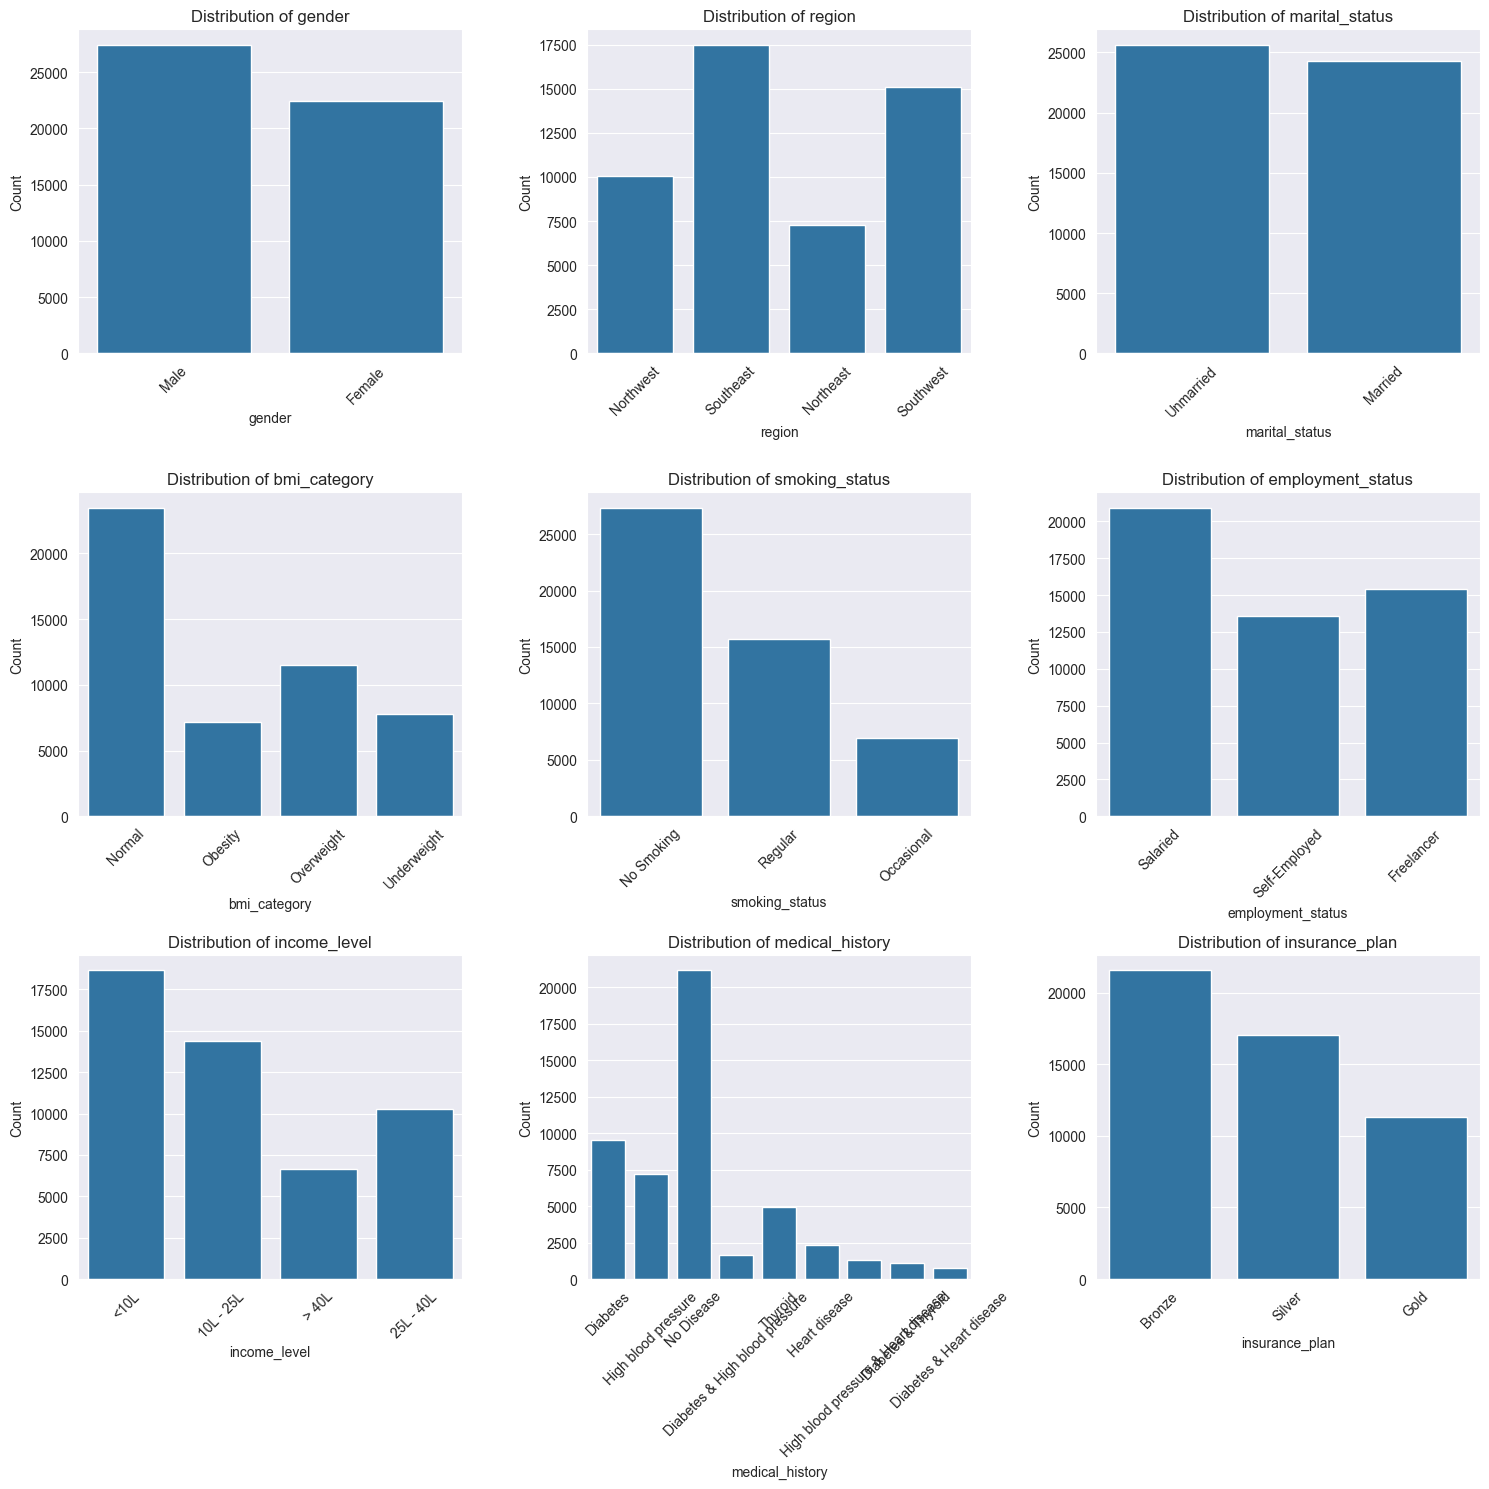

In [54]:
# Number of plots per row
plots_per_row = 3
num_cols = len(categorical_cols)
num_rows = (num_cols + plots_per_row - 1) // plots_per_row  # Calculate the required number of rows

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing
# tick_params(axis='x', rotation=45)

for i, col in enumerate(categorical_cols):
    sns.countplot(x=df2[col], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for i in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


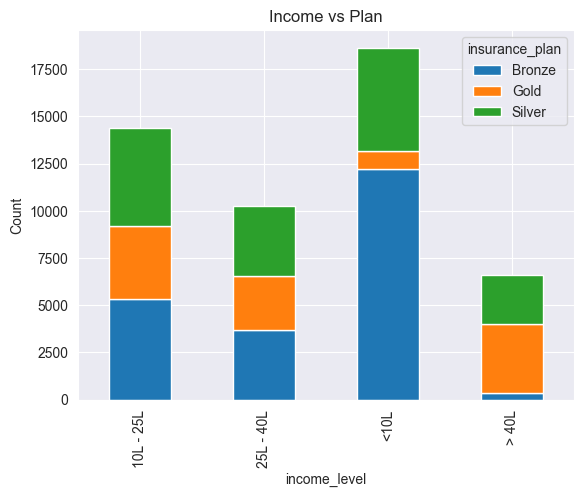

In [55]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

# Plotting the crosstab
crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

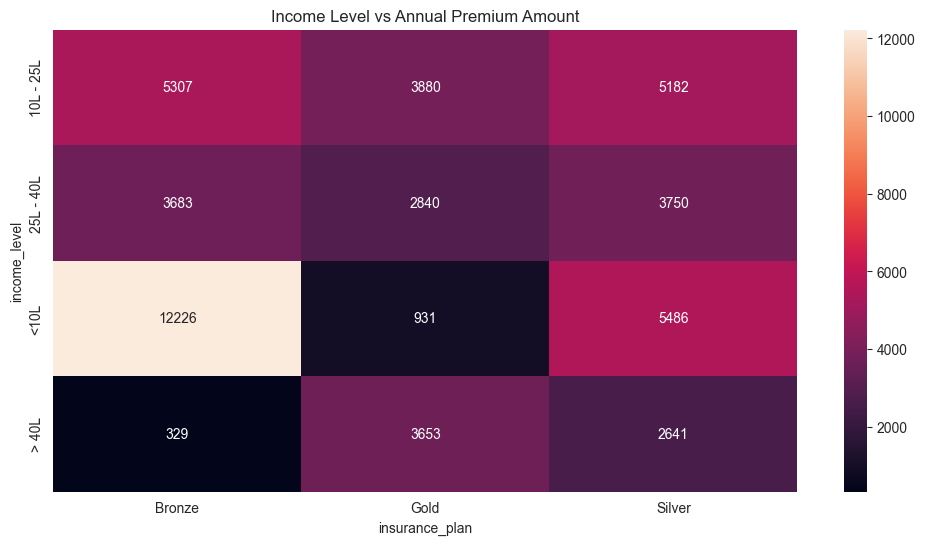

In [56]:
# create heatmap for the cross tab
plt.figure(figsize=(12, 6))
sns.heatmap(crosstab, cmap="rocket", annot=True, fmt="d")
plt.title("Income Level vs Annual Premium Amount")
plt.show()

### Feature Engineering

In [57]:
# From business understanding we have the below risk scores
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

In [58]:
df2["medical_history"].unique()
df2[["disease1","disease2"]] = df2["medical_history"].str.split("&", expand=True).apply(lambda x: x.str.lower().str.strip())
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,None
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None


In [59]:
df2["disease1"].fillna("none", inplace=True)
df2["disease2"].fillna("none", inplace=True)

df2["risk_score"] = 0
for index, row in df2.iterrows():
    risk_score = risk_scores[row["disease1"]] + risk_scores[row["disease2"]]
    df2.at[index, "risk_score"] = risk_score



/var/folders/bl/03dn4k0933q6q1tsklj_xsyr0000gn/T/ipykernel_66708/3001981777.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["disease1"].fillna("none", inplace=True)
/var/folders/bl/03dn4k0933q6q1tsklj_xsyr0000gn/T/ipykernel_66708/3001981777.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [60]:
pd.options.mode.chained_assignment = None  # Disable the warning

min_score = df2["risk_score"].min()
max_score = df2["risk_score"].max()

df2["normalized_risk_score"] = (df2["risk_score"] - min_score) / (max_score - min_score)
df2["normalized_risk_score"].describe()


count    49908.000000
mean         0.291831
std          0.287420
min          0.000000
25%          0.000000
50%          0.357143
75%          0.428571
max          1.000000
Name: normalized_risk_score, dtype: float64

### Feature Encoding

In [61]:
# In 'insurance_plan column', we have 3 unique values
# Encode the insurance plan column with label encoding because these are ordinal values
df2['insurance_plan'] = df2['insurance_plan'].replace({
    "Bronze": 1,
    "Silver": 2,
    "Gold": 3
})
df2["insurance_plan"].unique()
# df2["insurance_plan"] = df2["insurance_plan"].map({
#     "Bronze": 1,
#     "Silver": 2,
#     "Gold": 3
# })

/var/folders/bl/03dn4k0933q6q1tsklj_xsyr0000gn/T/ipykernel_66708/219683223.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['insurance_plan'] = df2['insurance_plan'].replace({


array([1, 2, 3])

In [62]:
# label encoding income_level
df2["income_level"].unique()
df2["income_level"] = df2["income_level"].replace({
    "<10L":1,
    '10L - 25L': 2,
    '25L - 40L':3,
    '> 40L': 4
})

/var/folders/bl/03dn4k0933q6q1tsklj_xsyr0000gn/T/ipykernel_66708/887112576.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2["income_level"] = df2["income_level"].replace({


In [152]:
nominal_cols = ["gender", "region","marital_status","bmi_category","smoking_status", "employment_status"]
df_encoded = pd.get_dummies(df2, columns=nominal_cols, drop_first=True)
df_encoded.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,False,False,True,False,False,False,False,False,True,False
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,True,False,False,True,False,False,False,True,True,False
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,False,False,False,False,False,False,False,False,False,True
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,True,False,False,False,False,False,False,False,True,False
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,False,False,True,False,True,False,False,True,False,True


In [153]:
# drop useless columns
df_encoded.drop(["medical_history", "disease1", "disease2", "normalized_risk_score"], axis=1,inplace=True)
df_encoded.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'risk_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [163]:
# make the column names in line with python standards
df_encoded.columns = df_encoded.columns.str.lower().str.replace('-','_')
df_encoded.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'risk_score', 'gender_male',
       'region_northwest', 'region_southeast', 'region_southwest',
       'marital_status_unmarried', 'bmi_category_obesity',
       'bmi_category_overweight', 'bmi_category_underweight',
       'smoking_status_occasional', 'smoking_status_regular',
       'employment_status_salaried', 'employment_status_self_employed'],
      dtype='object')

In [164]:
!pip install statsmodels

In [165]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [170]:
X = df_encoded.drop("annual_premium_amount", axis="columns")

X2 = X.copy()
X2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49908 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   age                              49908 non-null  int64
 1   number_of_dependants             49908 non-null  int64
 2   income_level                     49908 non-null  int64
 3   income_lakhs                     49908 non-null  int64
 4   insurance_plan                   49908 non-null  int64
 5   risk_score                       49908 non-null  int64
 6   gender_male                      49908 non-null  bool 
 7   region_northwest                 49908 non-null  bool 
 8   region_southeast                 49908 non-null  bool 
 9   region_southwest                 49908 non-null  bool 
 10  marital_status_unmarried         49908 non-null  bool 
 11  bmi_category_obesity             49908 non-null  bool 
 12  bmi_category_overweight          49908 non-null  bo

In [171]:
X2[X2.select_dtypes(include=['bool']).columns] = X2.select_dtypes(include=['bool']).astype('int8')
X2.dtypes

age                                int64
number_of_dependants               int64
income_level                       int64
income_lakhs                       int64
insurance_plan                     int64
risk_score                         int64
gender_male                         int8
region_northwest                    int8
region_southeast                    int8
region_southwest                    int8
marital_status_unmarried            int8
bmi_category_obesity                int8
bmi_category_overweight             int8
bmi_category_underweight            int8
smoking_status_occasional           int8
smoking_status_regular              int8
employment_status_salaried          int8
employment_status_self_employed     int8
dtype: object

In [172]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

cols_to_scale = ["age", "number_of_dependants", "income_level", "income_lakhs", "insurance_plan" , "risk_score"]

X2[cols_to_scale] = scaler.fit_transform(X2[cols_to_scale])

X2.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,bmi_category_obesity,bmi_category_overweight,bmi_category_underweight,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self_employed
0,0.148148,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [198]:

def get_cols_to_drop(data):
    '''
    :param data: pandas DataFrame with numerical columns
    :return: a list of columns to drop due to high VIF
    '''
    dropped_cols = []

    while True:
        vifs = calculate_vif(data)  # Calculate the VIF values for all columns
        max_vif = vifs["VIF"].max()  # Find the maximum VIF value

        if max_vif > 10:  # If max VIF is greater than 10, drop the most correlated column
            col = vifs[vifs.VIF == max].reset_index()["Column"][0]
            dropped_cols.append(col)  # Add to the list of dropped columns
            data = data.drop(columns=[col])  # Drop the column
        else:
            break  # Stop if no columns have VIF > 10

    return dropped_cols  # Return the list of dropped columns

cols_to_drop = get_cols_to_drop(X2)
cols_to_drop

['income_level']

In [199]:
df_encoded_2 = df_encoded.drop(columns=cols_to_drop)
df_encoded_2.head()

,age,number_of_dependants,income_lakhs,insurance_plan,annual_premium_amount,risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,bmi_category_obesity,bmi_category_overweight,bmi_category_underweight,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self_employed
0,26,0,6,1,9053,6,True,True,False,False,True,False,False,False,False,False,True,False
1,29,2,6,1,16339,6,False,False,True,False,False,True,False,False,False,True,True,False
2,49,2,20,2,18164,6,False,False,False,False,False,False,False,False,False,False,False,True
3,30,3,77,3,20303,0,False,False,True,False,False,False,False,False,False,False,True,False
4,18,0,99,2,13365,6,True,False,False,False,True,False,True,False,False,True,False,True


In [200]:
df_encoded_2.describe()

,age,number_of_dependants,income_lakhs,insurance_plan,annual_premium_amount,risk_score
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,1.794802,15765.739641,4.085638
std,13.681604,1.492032,22.170699,0.784919,8418.674061,4.023878
min,18.000000,0.000000,1.000000,1.000000,3501.000000,0.000000
25%,22.000000,0.000000,7.000000,1.000000,8608.000000,0.000000
50%,31.000000,2.000000,17.000000,2.000000,13928.000000,5.000000
75%,45.000000,3.000000,31.000000,2.000000,22270.500000,6.000000
max,72.000000,5.000000,100.000000,3.000000,43471.000000,14.000000


In [201]:
export_path = "../data/processed/premiums_2.csv"
df_encoded_2.to_csv(export_path, index=False)